In [29]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
from scipy.stats import multivariate_normal
from scipy import special
import scipy.integrate as integrate

In [30]:
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
data = pd.read_csv(url)
data = data.loc[(data.location=="Russia") & (data.date.apply(lambda x : datetime.fromisoformat(x)) >= datetime.fromisoformat("2020-03-03"))]
#  для упрощения обработки можно заменить в столбце new_cases все нули на единицы
data.loc[(data.new_cases == 0), "new_cases"] = 1
print(data.shape)
data.head()

(719, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
121390,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121391,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121392,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121393,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
121394,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [31]:
train, test = train_test_split(data, train_size=50, shuffle=False)

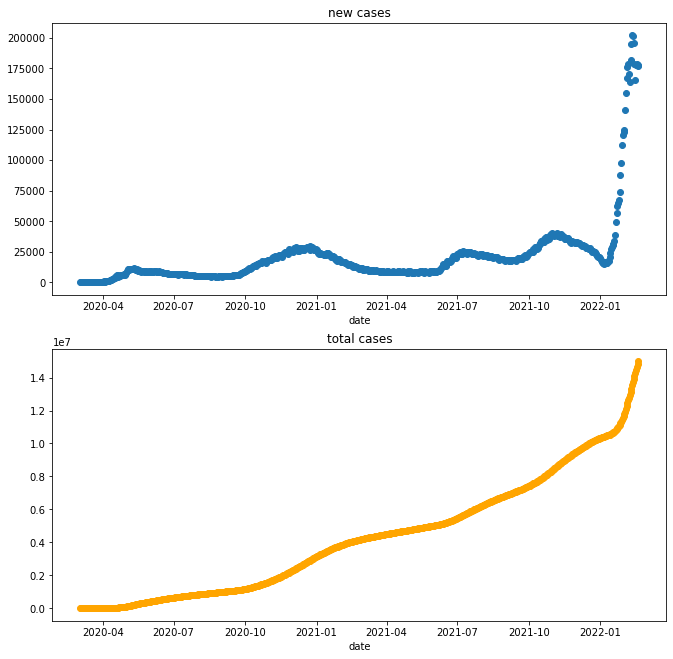

In [32]:
dates = list(data.date.apply(lambda x : datetime.fromisoformat(x)))
figsize = (11,11)
fig = plt.figure(figsize=figsize)
fig.tight_layout()
ax1 = fig.add_subplot(211)
ax1.set_xlabel('date')
ax1.set_title('new cases')
ax1.plot_date(dates, data.new_cases)
ax2 = fig.add_subplot(212)
ax2.set_xlabel('date')
ax2.set_title('total cases')
ax2.plot_date(dates, data.total_cases, color="orange")
plt.show()

In [5]:
def to_X_y(data):
  X = data.date.apply(lambda x : (datetime.fromisoformat(x).date() - datetime.fromisoformat('2020-03-03').date()).days).to_numpy().reshape(-1, 1)
  y = data[['new_cases', 'total_cases']].to_numpy()
  return X, y

#  y ~ exp(linear function(x))

$totalcases =  e^{Bx + C}$


$log(totalcases) =  Bx + C$

In [33]:
# broad prior distribution
prior_distrib = {
    "mu" : np.zeros(2),
    "sigma" : np.diag(2*[10])
}

class LinearRegression(BaseEstimator):
    def __init__(self, mu = prior_distrib["mu"], sigma = prior_distrib["sigma"]):
        self.mu = mu
        self.sigma = sigma
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        X = np.hstack((np.ones((len(X), 1)), X))
        w = np.linalg.pinv(X) @ y
        y_predict = X @ w
        var = (y - y_predict).var()
        self.sigma = np.linalg.inv(np.linalg.inv(self.sigma) + X.T @ X / var)
        self.mu = self.sigma @ (np.linalg.inv(self.sigma) @ self.mu + X.T @ y / var)

        return self

        
    def predict(self, X):
        X = np.hstack((np.ones((len(X), 1)), X))
        return X @ self.mu

In [34]:
X, y = to_X_y(train)
y_log = np.log(y)
model_total_cases = LinearRegression().fit(X, y_log[:, 1])

posterior_distrib = {
    "mu" : model_total_cases.mu,
    "sigma" : model_total_cases.sigma
}

In [35]:
def print_params(name, model):
  print(name)
  print("mean intercept {}  coeff {}".format(model.mu[0], model.mu[1]))
  print("variance intercept {} coeff {}".format(model.sigma[0][0], model.sigma[1][1]))

In [36]:
print_params("total cases", model_total_cases)

total cases
mean intercept 1.81902208015212  coeff 0.19834282433724937
variance intercept 0.009450828531332844 coeff 1.1692181175026685e-05


<ipython-input-37-d9fee98a4635>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


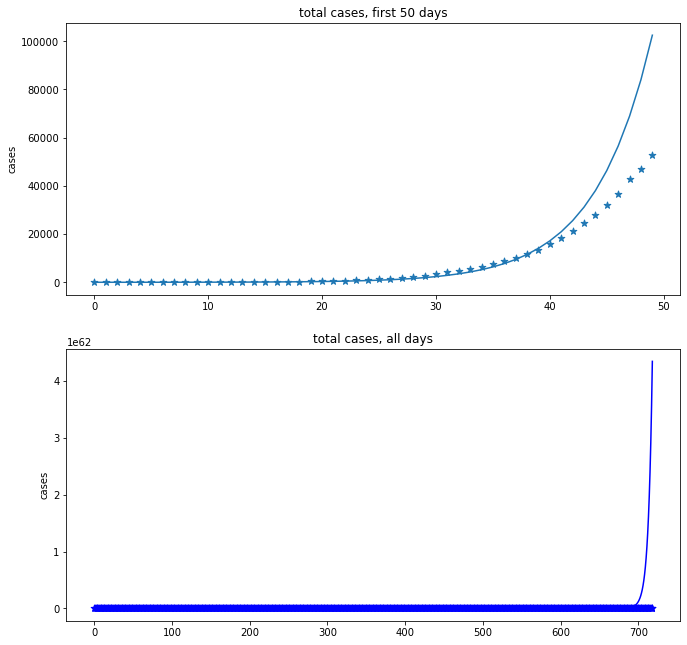

In [37]:
figsize = (11,11)
fig = plt.figure(figsize=figsize)
X, y = to_X_y(train)
ax1 = fig.add_subplot(211)
ax1.scatter(X, (y[:, 1]), marker='*', s=50) # total cases [train set; 1-50 days]
ax1.plot(X, np.exp(model_total_cases.predict(X)))
ax1.set_title('total cases, first 50 days')
ax1.set_ylabel('cases')
# ax1.set_yscale('log')
ax2 = fig.add_subplot(212) 
X, y = to_X_y(data)
ax2.scatter(X, (y[:, 1]), marker='*', s=50, color="blue") # total cases
ax2.plot(X, np.exp(model_total_cases.predict(X)), color="blue")
ax2.set_title('total cases, all days')
ax2.set_ylabel('cases')
# ax2.set_yscale('log')
fig.show()

In [38]:

def draw_distrib(distrib, N):
  coeff = 2
  delta = np.diag(np.sqrt(distrib["sigma"]))
  mean = distrib["mu"]
  X = np.linspace(-delta[0]*coeff + mean[0], delta[0]*coeff + mean[0], N)
  Y = np.linspace(-delta[1]*coeff + mean[1], delta[1]*coeff + mean[1], N)
  X, Y = np.meshgrid(X, Y)
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X
  pos[:, :, 1] = Y
  Z = multivariate_normal.pdf(pos, mean=distrib["mu"], cov=distrib["sigma"])

  fig = plt.figure(figsize=(8, 8))
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)

<ipython-input-38-34d99c4db539>:3: RuntimeWarning: invalid value encountered in sqrt
  delta = np.diag(np.sqrt(distrib["sigma"]))
<ipython-input-38-34d99c4db539>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)


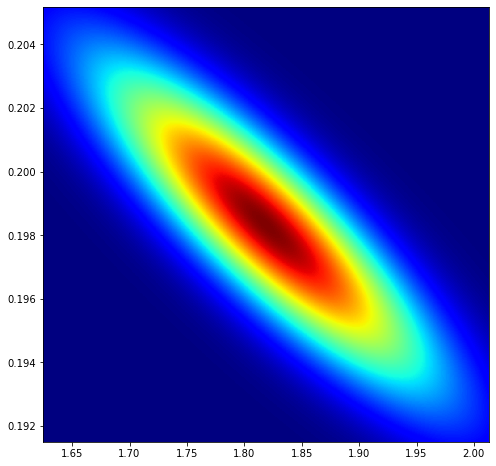

In [39]:
draw_distrib(posterior_distrib, 1000)

In [40]:
def sample(N, distrib):
  items  = np.random.multivariate_normal(distrib["mu"], distrib["sigma"], N)
  return items

In [41]:
params = sample(5000, posterior_distrib)

<ipython-input-42-50372c3fbfc1>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


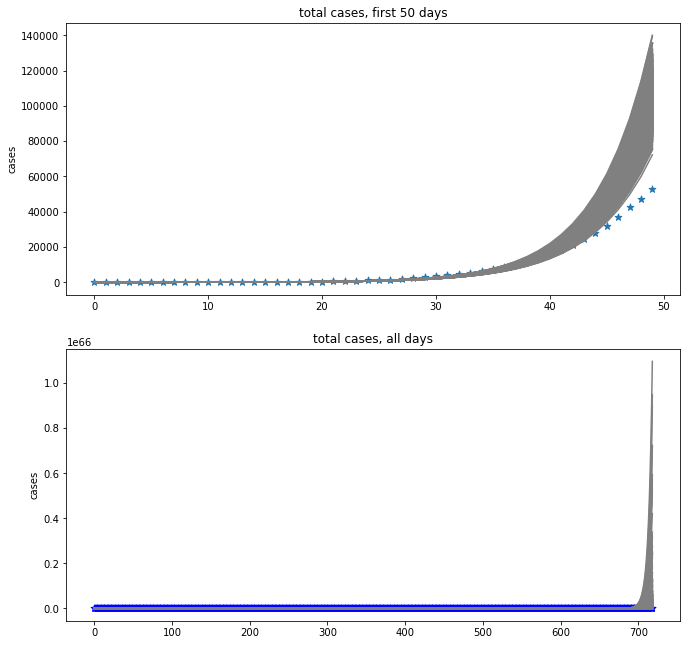

In [42]:
figsize = (11,11)
fig = plt.figure(figsize=figsize)
X, y = to_X_y(train)
ax1 = fig.add_subplot(211)
for p in params:
  ax1.plot(X, np.exp(p[1]*X + p[0]), color="gray")
ax1.scatter(X, (y[:, 1]), marker='*', s=50) # total cases [train set; 1-50 days]
ax1.set_title('total cases, first 50 days')
ax1.set_ylabel('cases')
# ax1.set_yscale('log')
ax2 = fig.add_subplot(212) 
X, y = to_X_y(data)
for p in params:
  ax2.plot(X, np.exp(p[1]*X + p[0]), color="gray")
ax2.scatter(X, (y[:, 1]), marker='*', s=50, color="blue") # total cases
ax2.set_title('total cases, all days')
ax2.set_ylabel('cases')
# ax2.set_yscale('log')
fig.show()

In [43]:
first_may = (datetime.fromisoformat('2020-05-01').date() - datetime.fromisoformat('2020-03-03').date()).days
first_june = (datetime.fromisoformat('2020-06-01').date() - datetime.fromisoformat('2020-03-03').date()).days
first_september = (datetime.fromisoformat('2020-09-01').date() - datetime.fromisoformat('2020-03-03').date()).days

In [44]:
def get_stats(x, params):
  y = np.array([np.exp(p[1]*x + p[0]) for p in params])
  return y.mean(), y.var()

In [45]:
X, y = to_X_y(data)
print("\033[1mFirst May\033[0m")
print("Predicted total cases mean={:.0f}, variance={:.0f}".format(*get_stats(first_may, params)))
print("Real total cases {:.0f}".format(y[first_may][1]))
print("\033[1mFirst June\033[0m")
print("Predicted total cases mean={:.0f}, variance={:.0f}".format(*get_stats(first_june, params)))
print("Real total cases {:.0f}".format(y[first_june][1]))
print("\033[1mFirst September\033[0m")
print("Predicted total cases mean={:.0f}, variance={:.0f}".format(*get_stats(first_september, params)))
print("Real total cases {:.0f}".format(y[first_september][1]))

First May
Predicted total cases mean=751647, variance=9031948214
Real total cases 114431
First June
Predicted total cases mean=358541936, variance=6737109547540282
Real total cases 414328
First September
Predicted total cases mean=34030585657721808, variance=378714401136083784889294800289792
Real total cases 997072


# Murray's law

https://www.medrxiv.org/content/10.1101/2020.03.27.20043752v1

$\Phi(x) = \frac{1}{\sqrt{2\pi}}  \cdot \int_{-\infty}^x e^{-t^2/2}~dt$

$totalcases =  \int_{-\infty}^x e^{At^2 + Bt + C}~dt$

$dailycases =  e^{At^2 + Bt + C}$

$log(dailycases) = At^2 + Bt + C$

In [26]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

prior_distrib = {
    "mu" : np.zeros(3),
    "sigma" : np.diag(3*[10])
}

X, y = to_X_y(train)
y = y[:, 0]
y = np.log(y)

def addSquareFeature(X):
    return np.hstack((np.square(X), X))

model = Pipeline([
                  ['tranformer', FunctionTransformer(addSquareFeature)],
                  ['linear_regression', LinearRegression(mu = prior_distrib["mu"], sigma = prior_distrib["sigma"])],
                  ]) 

model_total_cases = model.fit(X, y)

posterior_distrib = {
    "mu" : model_total_cases.named_steps['linear_regression'].mu,
    "sigma" : model_total_cases.named_steps['linear_regression'].sigma
}

<ipython-input-20-a4373dc823f7>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


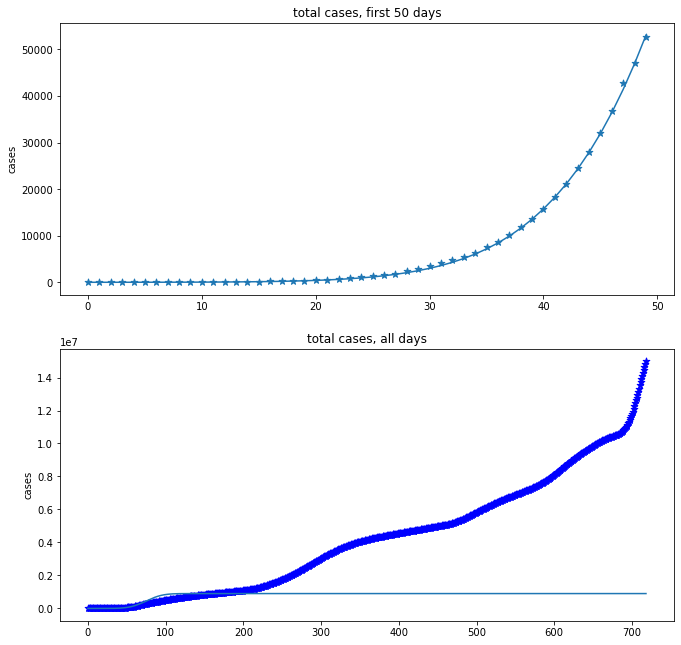

In [20]:
figsize = (11,11)
fig = plt.figure(figsize=figsize)
X, y = to_X_y(train)
ax1 = fig.add_subplot(211)
ax1.scatter(X, (y[:, 1]), marker='*', s=50) # total cases [train set; 1-50 days]
ax1.plot(X, np.cumsum(np.exp(model_total_cases.predict(X)), axis = 0 ))
ax1.set_title('total cases, first 50 days')
ax1.set_ylabel('cases')
# ax1.set_yscale('log')
ax2 = fig.add_subplot(212) 
X, y = to_X_y(data)
ax2.scatter(X, (y[:, 1]), marker='*', s=50, color="blue") # total cases
ax2.plot(X, np.cumsum(np.exp(model_total_cases.predict(X)), axis = 0 ))
ax2.set_title('total cases, all days')
ax2.set_ylabel('cases')
# ax2.set_yscale('log')
fig.show()

In [21]:
params = sample(5000, posterior_distrib)

<ipython-input-22-597a9a1cd97b>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


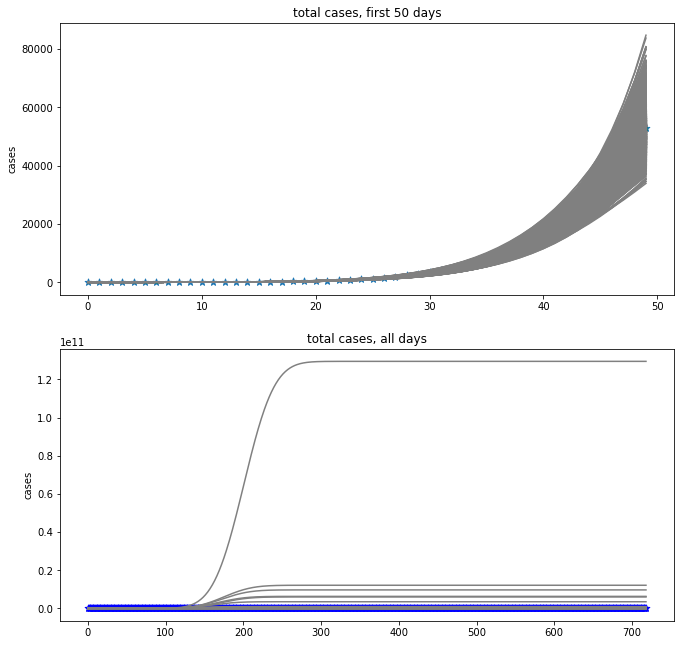

In [22]:
end_predictions = []

figsize = (11,11)
fig = plt.figure(figsize=figsize)
X, y = to_X_y(train)
ax1 = fig.add_subplot(211)
for p in params:
  y_pred = np.cumsum(np.exp(p[0] + p[1]*np.square(X) + p[2]*X), axis = 0)
  ax1.plot(X, y_pred, color="gray")
ax1.scatter(X, (y[:, 1]), marker='*', s=50) # total cases [train set; 1-50 days]
ax1.set_title('total cases, first 50 days')
ax1.set_ylabel('cases')
# ax1.set_yscale('log')
ax2 = fig.add_subplot(212) 
X, y = to_X_y(data)
for p in params:
  y_pred = np.cumsum(np.exp(p[0] + p[1]*np.square(X) + p[2]*X), axis = 0)
  end_predictions+= [y_pred]
  ax2.plot(X, y_pred, color="gray")
ax2.scatter(X, (y[:, 1]), marker='*', s=50, color="blue") # total cases
ax2.set_title('total cases, all days')
ax2.set_ylabel('cases')
# ax2.set_yscale('log')
fig.show()

In [27]:
print("\033[1mPessimistic scenario\033[0m")
print("Total cases {:.0f}".format(np.quantile(end_predictions, 0.9)))
print("\033[1mOptimistic scenario\033[0m")
print("Total cases {:.0f}".format(np.quantile(end_predictions, 0.1)))

Pessimistic scenario
Total cases 4688948
Optimistic scenario
Total cases 193633
